In [45]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Dimensions of the bipolar image: (245, 245)


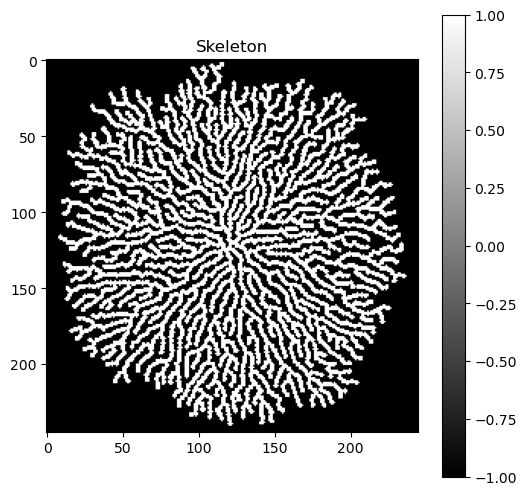

In [46]:
import numpy as np
import matplotlib.image as mpimg

# Step 1: Load the RGB image
image_path = os.getcwd() + "\\Mycelium_model_real_image.png"
rgb_image = mpimg.imread(image_path)

# Step 2: Use only the first channel for simplicity
first_channel = rgb_image[:, :, 0]  # Extract the first channel
threshold = 0.5
skeleton = np.where(first_channel < threshold, 1, -1)  # Create bipolar image directly

# Step 3: Extract dimensions
dimensions = skeleton.shape
print(f"Dimensions of the bipolar image: {dimensions}")

# Step 4: Plot the bipolar image
plt.figure(figsize=(6, 6))
plt.title('Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.colorbar()
plt.show()


In [47]:
# Hyperparameters
grid_size = skeleton.shape[0]
total_iterations = 1000

In [48]:
substrate_val = 0.3

# Reaction-Diffusion parameters
pa = 0.6  # Coefficient for the activator's reaction rate.
pb = 0.8  # Coefficient controlling the interaction between activator and suppressor.
pe = 4.5  # Coefficient for the suppressor's reaction term (controls how the suppressor inhibits the activator).
d = 50  # Diffusion rate for the suppressor (higher value means faster diffusion of the suppressor).
dt = 1e-1  # Time step size for the simulation (controls how fast the system evolves with each iteration).
threshold = 1 # Threshold for determining whether the activator concentration affects the suppressor.
gamma = 625  # Reaction rate scaling factor (affects the speed of the reaction between the activator, suppressor, and mycelium).
ph = 1  # Coefficient related to the growth of the mycelium (scaling factor for the mycelium growth dynamics).
amax = 40  # Maximum allowed concentration for the activator (prevents uncontrolled growth of the activator).
smax = 80  # Maximum allowed concentration for the suppressor (prevents uncontrolled growth of the suppressor).
width = 2.0  # Controls the width of the dendrites formed during the growth process (affects the spatial spread of the reaction).

(245, 245)


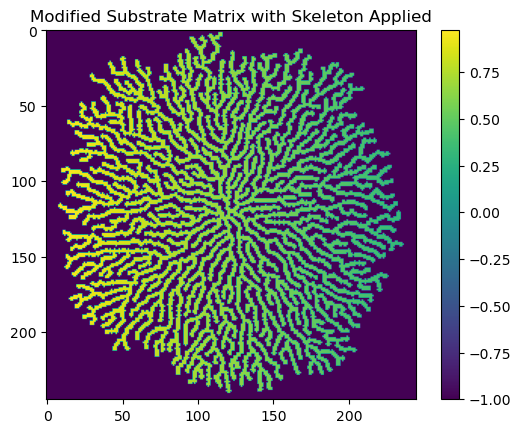

In [49]:
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2

n = np.linspace(1, substrate_val, grid_size)
n = np.tile(n, (grid_size, 1))

# Step 2: Apply the skeleton mask
n[skeleton < 1] = -1

print(n.shape)

plt.imshow(n, cmap='viridis')  # Using viridis for better color distinction
plt.colorbar()
plt.title("Modified Substrate Matrix with Skeleton Applied")
plt.show()

n = torch.tensor(n, dtype=torch.float32, device=device)

In [50]:
# Example initialization of n, make sure this is correct as per your setup

# Initialize matrices
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

# Initial activator and suppressor states
for k in range(-5, 6):  # This ranges from -5 to 5, inclusive
    size = 2 * abs(k) + 1  # This computes the size of the square
    start_idx = mid + k if k < 0 else mid - k
    if start_idx + size <= grid_size:  # Check to ensure indices are within bounds
        random_tensor = torch.randint(0, 5001, (size, size), device=device) / 10000
        u[start_idx:start_idx+size, start_idx:start_idx+size] = 0.5 + random_tensor / (0.5 * n[start_idx:start_idx+size, start_idx:start_idx+size])
        v[start_idx:start_idx+size, start_idx:start_idx+size] = 0.1 + random_tensor / (0.5 * n[start_idx:start_idx+size, start_idx:start_idx+size])
        c[start_idx:start_idx+size, start_idx:start_idx+size] = 1

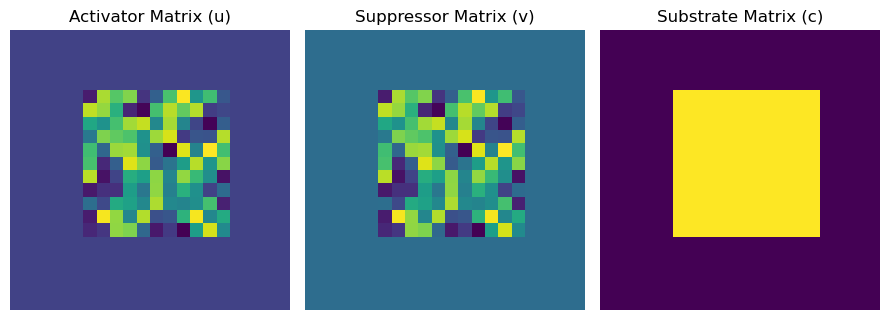

In [51]:
# Plotting the matrices in one row
fig, axs = plt.subplots(1, 3, figsize=(9, 9))  # Adjusted for a single row with four plots

# Define limits for zooming into the center
x_limits = (mid-11, mid+10)
y_limits = (mid-11, mid+10)

# Plot u matrix
axs[0].imshow(u.cpu().numpy(), cmap='viridis')
axs[0].set_title('Activator Matrix (u)')
axs[0].axis('off')
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)

# Plot v matrix
axs[1].imshow(v.cpu().numpy(), cmap='viridis')
axs[1].set_title('Suppressor Matrix (v)')
axs[1].axis('off')
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)

# Plot c matrix
axs[2].imshow(c.cpu().numpy(), cmap='viridis')
axs[2].set_title('Substrate Matrix (c)')
axs[2].axis('off')
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)

plt.tight_layout()
plt.show()

In [52]:
def update_visualization(step, u, v, c, n):
    fig = plt.figure(figsize=(7, 7))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().numpy(), cmap='jet', vmin=0, vmax=amax)
    ax1.set_title(f'Activator u at iteration {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().numpy(), cmap='jet', vmin=0, vmax=smax)
    ax2.set_title(f'Suppressor v at iteration {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().numpy(), cmap='jet', vmin=-1, vmax=1)
    ax3.set_title(f'Mycelium at iteration {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().numpy(), cmap='jet')
    ax4.set_title('Substrate')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

In [53]:
# Laplacian (Diffusion) Kernel Weights
lap_side = 0.35
lap_diag = 0.1
lap = 1/9

# Depth (Size) of Kernel
depth = 2

# Plasma Membrane of Mycelium
ij_mat = torch.zeros((grid_size, grid_size), device=device)

In [54]:
# Pre-calculate the Laplacian kernel indices and weights if they remain constant
lap_kernel = torch.zeros((2*depth+1, 2*depth+1), device=device)
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            lap_kernel[depth, depth] = lap
        elif abs(dx) == abs(dy):
            lap_kernel[depth + dx, depth + dy] = lap_diag
        else:
            lap_kernel[depth + dx, depth + dy] = lap_side

print(lap_kernel)

tensor([[0.1000, 0.3500, 0.3500, 0.3500, 0.1000],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.3500, 0.3500, 0.1111, 0.3500, 0.3500],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.1000, 0.3500, 0.3500, 0.3500, 0.1000]], device='cuda:0')


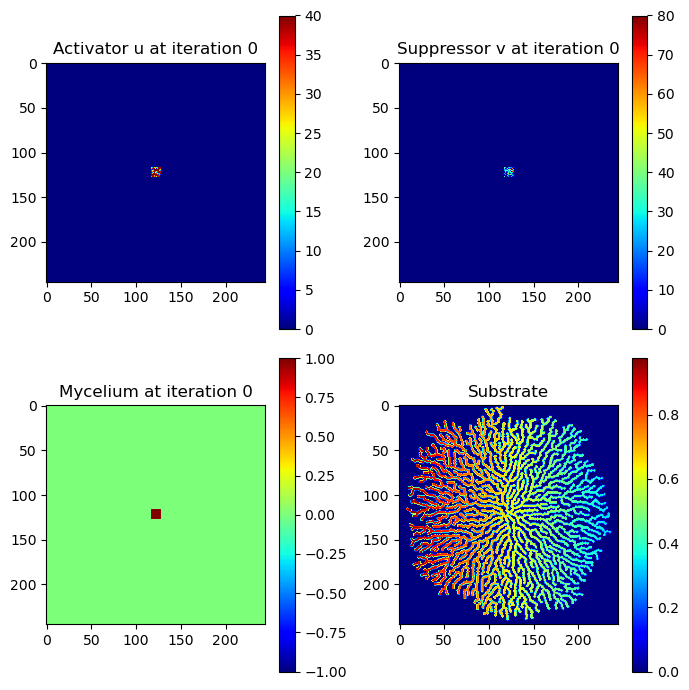

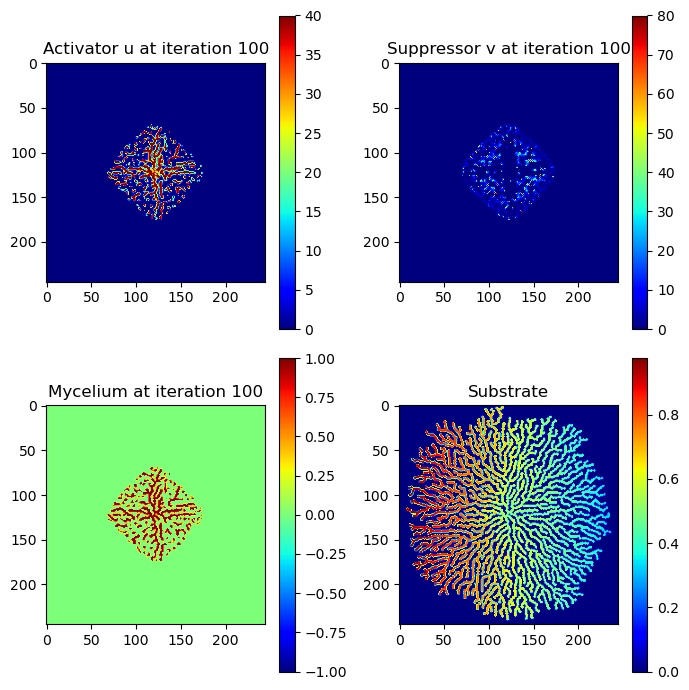

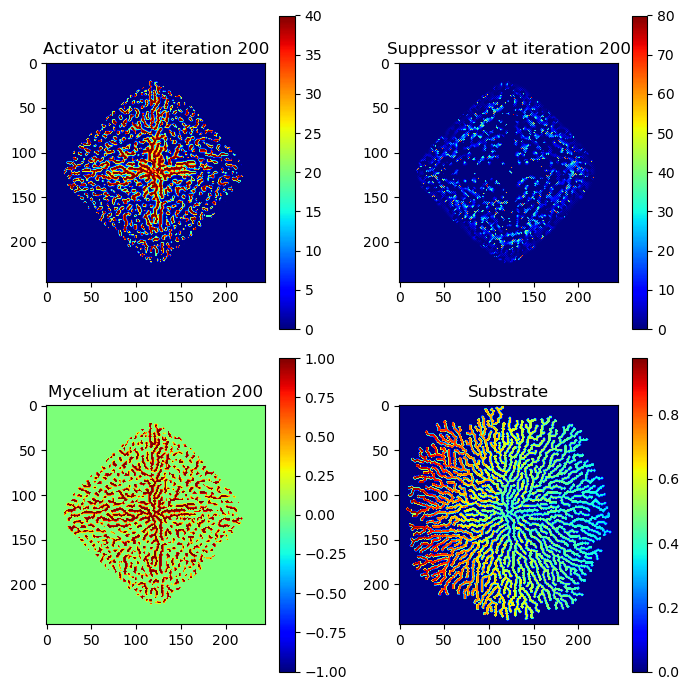

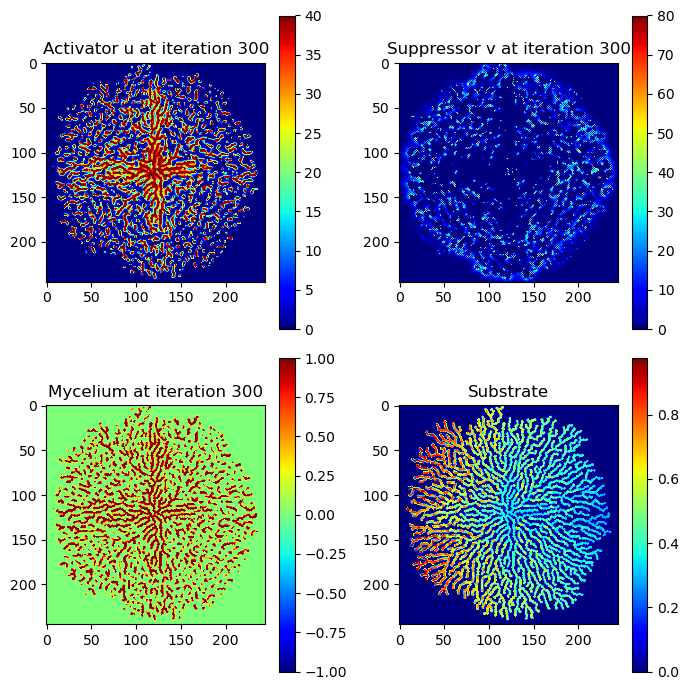

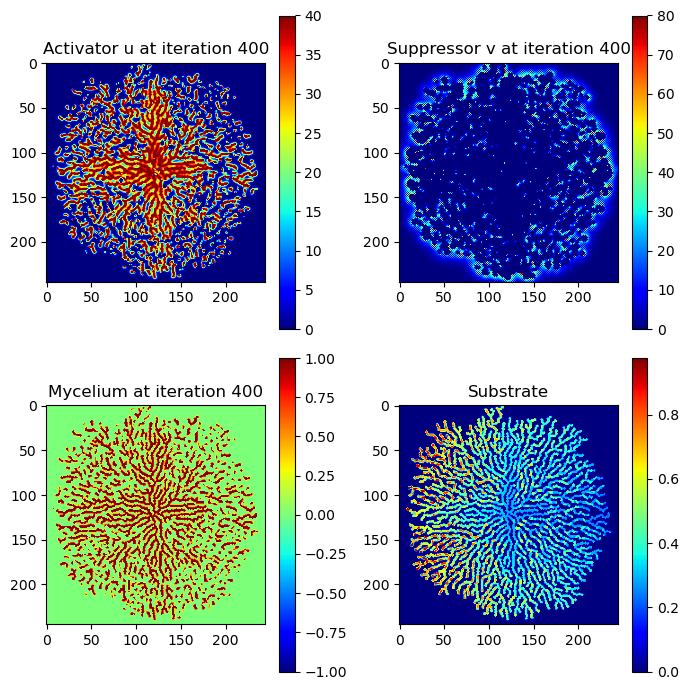

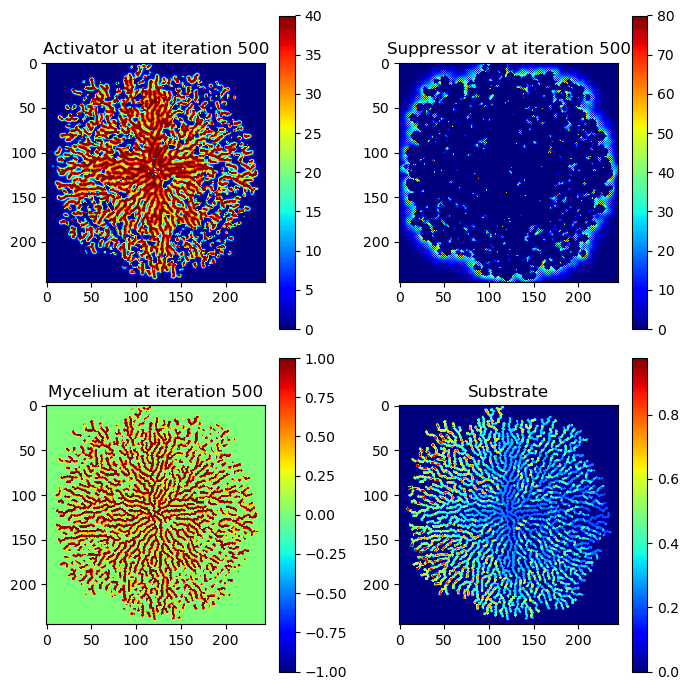

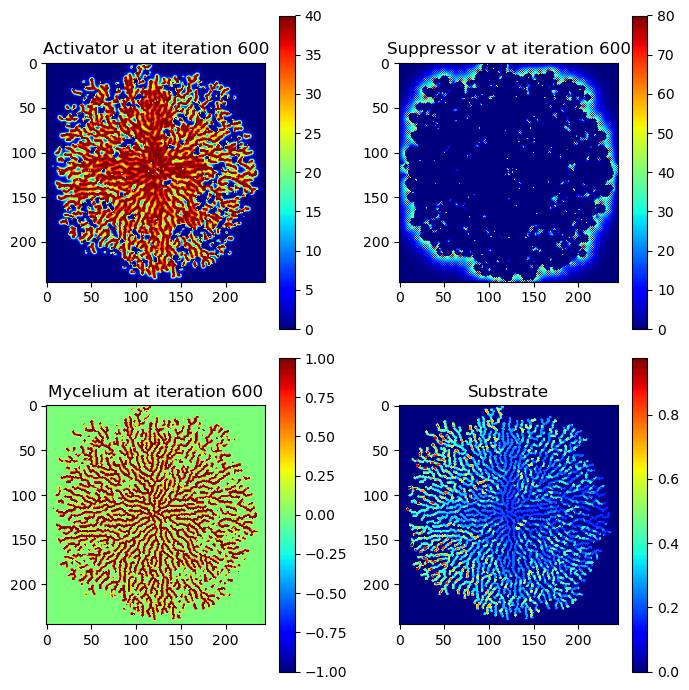

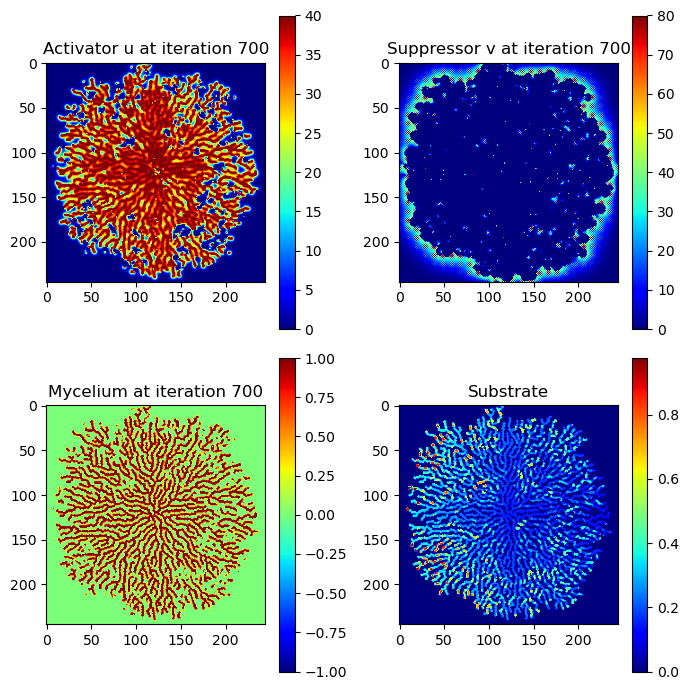

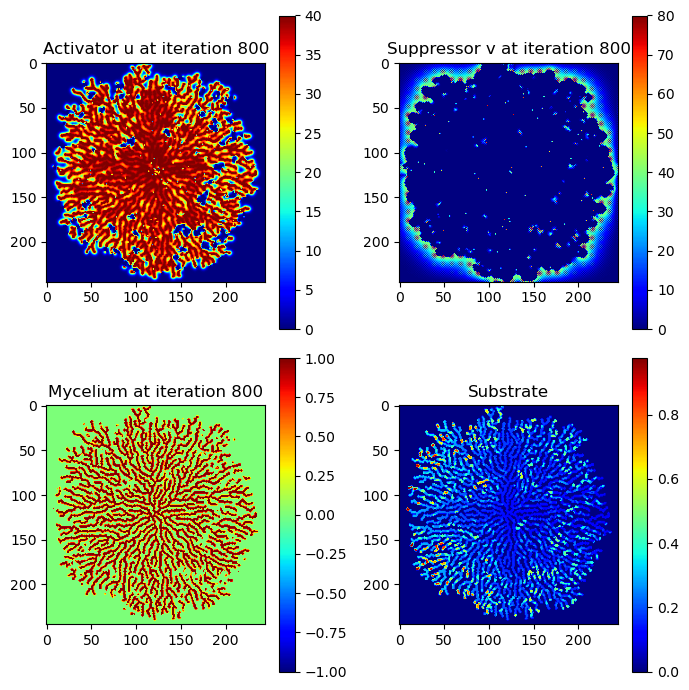

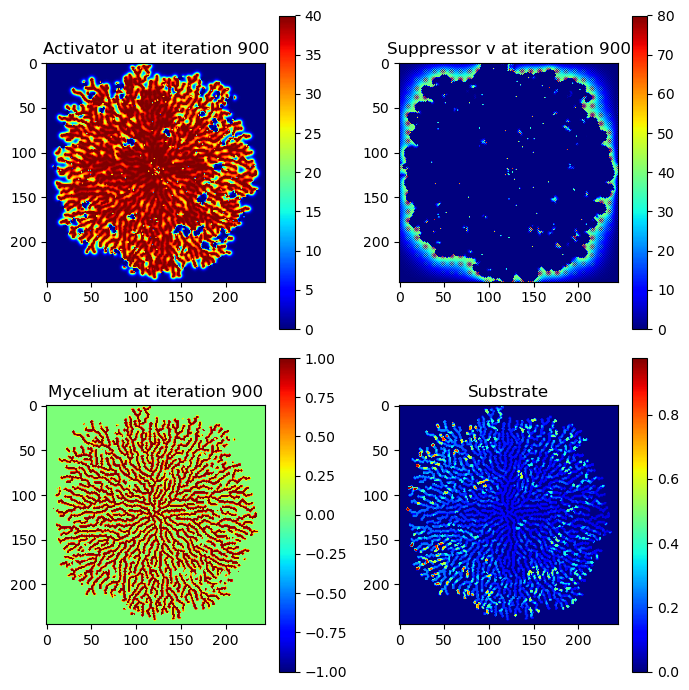

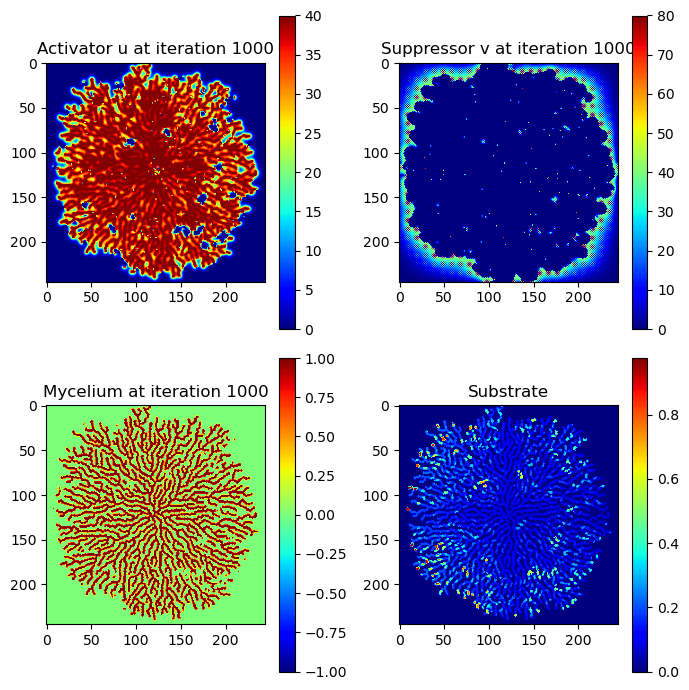

In [55]:
# Main simulation loop
base_consumption_rate = 0.002
for step in range(total_iterations+1):
    # Reaction Terms that control chemical behavior
    f_uv = width * (pa * u + u ** 2 - pb * u * v) * n
    g_uv = pe * u ** 3 - v  # Enhanced suppressor response

    # Incorporate the radius of the plasmatic membrane
    ij_mat = torch.zeros_like(ij_mat)  # Reset each iteration
    ij_mat[c > 0.5] = 1  # Fill ij_mat based on the mycelium matrix

    # Update activator and suppressor
    v_new = v + dt * (d * (0.05 * (torch.roll(v, 1, 0) + torch.roll(v, -1, 0) +
                                    torch.roll(v, 1, 1) + torch.roll(v, -1, 1)) - 0.2 * v) + gamma * g_uv)
    u_new = u + dt * (0.05 * (torch.roll(u, 1, 0) + torch.roll(u, -1, 0) +
                              torch.roll(u, 1, 1) + torch.roll(u, -1, 1)) - 0.2 * u + gamma * f_uv)

    # Apply threshold and adjust alpha
    alpha = torch.where(u <= threshold, 0.49, 0.49 - 2.5 * (u - threshold))
    v_new[u > threshold] = 0

    # Update c using alpha and apply limits
    c_new = c + dt * (gamma * ph * c * (alpha - c) * (c - 1))
    c_new = torch.where(alpha < 0, torch.ones_like(c_new), c_new)
    c_new[n == 0] = -1  # Growth is prevented where nutrients are 0 (rocks)
    
    c_new = torch.clamp(c_new,0,torch.max(c_new))

    # Limiters of activator and suppressor to avoid exponential growth
    u_new = torch.clamp(u_new, 0, amax)
    v_new = torch.clamp(v_new, 0, smax)

    # Proportional Nutrient Consumption: Mycelium consumes nutrients based on available nutrients
    n = n - base_consumption_rate * c_new * n  # Consumption proportional to available nutrients and mycelium
    n = torch.clamp(n, min=0)  # Prevent negative nutrient values

    # Update variables
    u, v, c = u_new, v_new, c_new

    # Visualization every 20 steps
    if step % 100 == 0:
        update_visualization(step, u, v, c, n)